In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Lambda
from keras.constraints import maxnorm
from keras.optimizers import adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.
/Users/jackholder/anaconda2/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
np.random.seed(10)

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [62]:
import tensorflow as tf
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import check_random_state

import scipy.sparse as sp

def gaussian_random_tensor(n_components, n_features, sign, random_state=None):
    rng = check_random_state(random_state)
    components = rng.normal(loc=0.0,
                            scale=1.0 / np.sqrt(n_components),
                            size=(n_components, n_features))
    sign_x = lambda t: np.sign(t)
    vfunc = np.vectorize(sign_x)
    if sign == 1:
        vfunc(components)
    return (tf.convert_to_tensor(components, dtype = 'float32'))

def _check_density(density, n_features):
    """Factorize density check according to Li et al."""
    if density == 'auto':
        density = 1 / np.sqrt(n_features)
    elif density <= 0 or density > 1:
        raise ValueError("Expected density in range ]0, 1], got: %r"
                         % density)
    return density

def sparse_random_tensor(n_components, n_features, density='auto',
                         random_state=None):
 
    density = _check_density(density, n_features)
    rng = check_random_state(random_state)
    if density == 1:
        # skip index generation if totally dense
        components = rng.binomial(1, 0.5, (n_components, n_features)) * 2 - 1
        return 1 / np.sqrt(n_components) * components
    else:
        indices = []
        offset = 0
        indptr = [offset]
        for i in range(n_components):
            # find the indices of the non-zero components for row i
            n_nonzero_i = rng.binomial(n_features, density)
            indices_i = sample_without_replacement(n_features, n_nonzero_i,
                                                   random_state=rng)
            indices.append(indices_i)
            offset += n_nonzero_i
            indptr.append(offset)
        indices = np.concatenate(indices)
        # Among non zero components the probability of the sign is 50%/50%
        data = rng.binomial(1, 0.5, size=np.size(indices)) * 2 - 1
        # build the CSR structure by concatenating the rows
        components = sp.csr_matrix((data, indices, indptr),
                                   shape=(n_components, n_features))
        return tf.convert_to_tensor(np.sqrt(1 / density) / np.sqrt(n_components) * components)


def project(x, ncomp, sign): #ncomp is the number of dimensions we want to shrink to 
    features = K.int_shape(x)[1] # number of features
    Y = gaussian_random_tensor(ncomp, features, sign) # matrix has same # columns as the vector has rows
    x = tf.transpose(x) # makes x a column vector
    X_new = K.dot(Y, x)
    X_new = tf.transpose(X_new)
    return X_new

In [93]:
dims = [2048, 1024, 512, 256, 128, 64]
import time
accuracy = []
size = []
times = []
epochs = 10

for d in dims:
    start = time.time()
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    if d != 2048:
        model.add(Lambda (lambda x: project(x, d, 0)))
        
    model.add(Dense(d, activation='relu', kernel_constraint=maxnorm(3)))

    model.add(Dense(50, activation='relu', kernel_constraint=maxnorm(3)))
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
    a = model.evaluate(X_test, y_test, verbose=0)[1]
    
    end = time.time()
    t = end - start
    accuracy.append(a)
    size.append(d)
    times.append(t)

import pandas as pd
df = pd.DataFrame({'Size': size, 'Accuracy': accuracy, 'Runtime': times})
    

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 445s - loss: 1.4702 - acc: 0.4634 - val_loss: 1.1446 - val_acc: 0.5869
Epoch 2/10
50000/50000 [==============================] - 424s - loss: 1.0591 - acc: 0.6218 - val_loss: 0.9916 - val_acc: 0.6496
Epoch 3/10
50000/50000 [==============================] - 424s - loss: 0.8809 - acc: 0.6869 - val_loss: 0.9185 - val_acc: 0.6781
Epoch 4/10
50000/50000 [==============================] - 420s - loss: 0.7547 - acc: 0.7335 - val_loss: 0.8557 - val_acc: 0.7043
Epoch 5/10
50000/50000 [==============================] - 418s - loss: 0.6555 - acc: 0.7687 - val_loss: 0.8422 - val_acc: 0.7081
Epoch 6/10
50000/50000 [==============================] - 418s - loss: 0.5565 - acc: 0.8052 - val_loss: 0.8484 - val_acc: 0.7057
Epoch 7/10
50000/50000 [==============================] - 419s - loss: 0.4744 - acc: 0.8332 - val_loss: 0.8846 - val_acc: 0.7063
Epoch 8/10
50000/50000 [=======================

In [94]:
df['time_saved'] = (max(df['Runtime']) - df['Runtime']) / max(df['Runtime'])
df['acc_lost'] = (max(df['Accuracy']) - df['Accuracy'])
df

,Accuracy,Runtime,Size,time_saved,acc_lost
0,0.7107,4258.122126,2048,0.000000,0.0000
1,0.6990,3376.166322,1024,0.207123,0.0117
2,0.6820,2963.589998,512,0.304015,0.0287
3,0.6705,2861.366039,256,0.328022,0.0402
4,0.6462,2840.649288,128,0.332887,0.0645
5,0.6103,2821.885366,64,0.337293,0.1004


In [95]:
df.to_csv('Cifar_gaussian_no_sign.csv')

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_165 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 32, 16, 16)        0         
_________________________________________________________________
dropout_83 (Dropout)         (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 32, 16, 16)        9248      
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 32, 8, 8)          0         
_________________________________________________________________
flatten_83 (Flatten)         (None, 2048)              0         
_________________________________________________________________
lambda_71 (Lambda)           (None, 64)                0         
__________

In [81]:
model.get_layer('dense_156')

In [83]:
from keras.models import Model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('dense_156').output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [86]:
from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2, random_state=0)
ts = t_sne.fit_transform(intermediate_output)

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt

ValueError: c of shape (10000, 10, 3) not acceptable as a color sequence for x with size 10000, y with size 10000

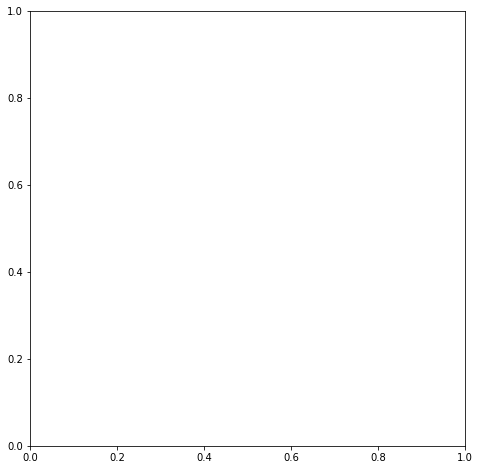

In [92]:
import seaborn as sns

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

scatter(ts, y_test)